HMM-DDM: 24-Hour rat data
========================
In this notebook we will analyse a dataset of rats performing a two-alternative forced choice (TAFC) task developed in Kane, Senne, and Scott, 2025. Rats performed this task in a live-in operant training facility and were able to perform as many trials as they desired.

In [1]:
using HiddenMarkovModels
using DriftDiffusionModels
using Plots
using CSV
using DataFrames
using Dates
using Random
using Distributions

## Load and Preprocess the data

In [2]:
ddir = "../data/flashes_df_cleaned.csv"
# load in the data
df = CSV.File(ddir) |> DataFrame;

In [3]:
# get the list of names of the rats
rats = unique(df.name)

# pick a rat of interest
roi = rats[1] # change this to the rat you want to analyze

# get the data for the rat of interest
rat_df = df[df.name .== roi, :]

# get the RT and correct/incorrect chocies for said rat. Map 0 -> -1
outcomes = df[df.name .== roi, :outcome]
outcomes[outcomes .== 0] .= -1

# now RTs 
rts = df[df.name .== roi, :rt]

# Extract just the date part from the timestamp strings
dates = [Date(split(dt)[1]) for dt in rat_df.trial_datetime]

# Get unique dates in chronological order
unique_dates = sort(unique(dates))

# Create a vector of vectors, where each inner vector contains DDMResults for one day
results_by_date = Vector{Vector{DDMResult}}()

for date in unique_dates
    # Get indices for this date
    day_indices = findall(dates .== date)
    
    # Extract RTs and outcomes for this date
    day_rts = rts[day_indices]
    day_outcomes = outcomes[day_indices]
    
    # Create DDMResult objects for this day
    day_results = [DDMResult(rt, choice) for (rt, choice) in zip(day_rts, day_outcomes)]
    
    # Add to our vector of vectors
    push!(results_by_date, day_results)
end

# Now calculate the sequence ends (cumulative sum of lengths)
seq_ends = cumsum([length(seq) for seq in results_by_date])

# Concatenate all results into a single vector
all_results = reduce(vcat, results_by_date)

26897-element Vector{DDMResult}:
 DDMResult(1.0066, -1)
 DDMResult(2.6136, 1)
 DDMResult(1.9688, 1)
 DDMResult(1.2156, 1)
 DDMResult(1.302, 1)
 DDMResult(1.1713, -1)
 DDMResult(1.5016, 1)
 DDMResult(1.1515, 1)
 DDMResult(1.7842, 1)
 DDMResult(0.9828, -1)
 ⋮
 DDMResult(1.7741, 1)
 DDMResult(1.2505, 1)
 DDMResult(1.1469, 1)
 DDMResult(1.3238, 1)
 DDMResult(0.8646, -1)
 DDMResult(0.9367, -1)
 DDMResult(1.0928, 1)
 DDMResult(0.9537, 1)
 DDMResult(1.2587, 1)

## Perform Cross Validation

For these CV procedure we will do the following procedure:

- Shuffle the data across sessions
- Split the data into 5 folds
- For each numbert of states K in [2, 3, 4, 5]
    - For each fold
        - For 10 iterations
            - Randomly initialize the model parameters
            - Fit the model to the training data
            - Evaluate the model on the test data
            - Store the model parameters and performance metrics
        - Store the best model parameters and performance metrics
        - Compute the mean and standard deviation of the performance metrics across iterations

- Refit the best model of the selected K states to the entire dataset

In [4]:
cv_results, nobs = crossvalidate(results_by_date; n_states=2, n_folds=3, n_iter=3)

┌ Info: ⇢ evaluating 1 hidden state(s)
└ @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\Utilities.jl:51
┌ Info: ⇢ evaluating 2 hidden state(s)
└ @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\Utilities.jl:51


(ll = Dict(2 => [-3150.098688931106 -2486.9065661470645 -2260.862196797379; -2225.278732170556 -1740.1264212675214 -1604.2147077995915; -2225.276299104812 -1740.1213237424174 -2312.4109175732087], 1 => [-3159.8258747170303 -2737.4876508560783 -2322.1442448068233; -3159.8258747174314 -2737.487650856117 -2322.1442448067774; -3159.825874717865 -2737.487650855467 -2322.144244806651]), nobs = [8940 10037 7920; 8940 10037 7920; 8940 10037 7920])

In [7]:
function calculate_ll_ratio(ℓℓ::Float64, ℓℓ₀::Float64, n::Int)
    ll_ratio = ℓℓ - ℓℓ₀
    return ll_ratio / (n * log(2))
end

calculate_ll_ratio (generic function with 1 method)

In [13]:
mean(calculate_ll_ratio.( cv_results[2], cv_results[1], nobs ), dims=1)

1×3 Matrix{Float64}:
 0.101065  0.107578  0.0479043

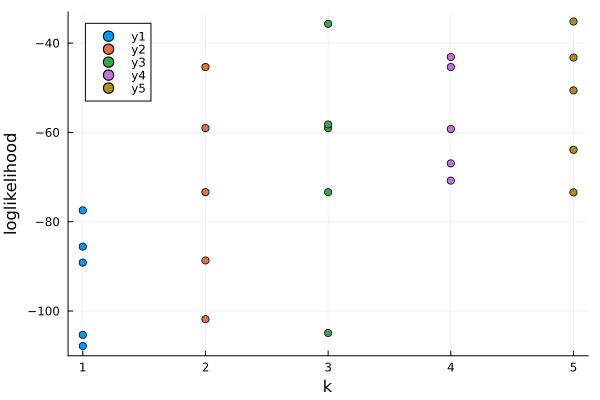

In [20]:
plot(xlabel="k", ylabel="loglikelihood")
for i in 1:5
    scatter!([i for _ in 1:5], cv_results[i])
end
display(current())

In [5]:
# generate a HMM to start from
trans_guess = [0.5 0.5; 0.5 0.5]
init_guess = [0.99, 0.01]

ddm_1_guess = DriftDiffusionModel(10, 1, 0, 1)
ddm_2_guess = DriftDiffusionModel(1, 0.1, 0, 1)

dists_guess = [ddm_1_guess, ddm_2_guess]

hmm = PriorHMM(init_guess, trans_guess, dists_guess, 2., 2.)

hmm_est, lls = baum_welch(hmm, all_results; seq_ends=seq_ends)

(PriorHMM{Float64, DriftDiffusionModel}([0.536637452498334, 0.46336254750166594], [0.8962475811732459 0.1037524188267542; 0.14736434761665929 0.8526356523833407], DriftDiffusionModel[DriftDiffusionModel(4.009817996322776, 3.0730042319699877, -0.10664316096482922, 1.0), DriftDiffusionModel(5.4669025224046095, 6.06903833042791, -0.03665584001602198, 1.0)], 2.0, 2.0), [-57621.99526233431, -7858.577576650307, -7827.40334919927, -7781.945536896552, -7709.467698992802, -7611.862681456311, -7511.713268571765, -7433.292058066688, -7376.056575551577, -7328.897425085245  …  -5253.870796018144, -5253.869426916055, -5253.868339143386, -5253.867469021763, -5253.866768322909, -5253.866200351155, -5253.865737045094, -5253.86535682963, -5253.865043020811, -5253.864782638428])

## Confirm the LL converges!

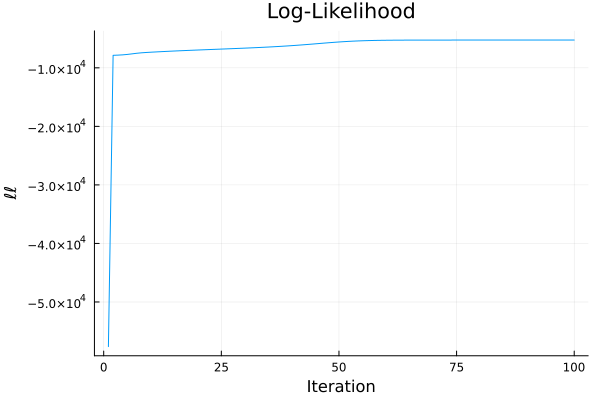

In [6]:
plot(lls, title="Log-Likelihood", xlabel="Iteration", ylabel="ℓℓ", legend=false)

## Plot the Posterior Distribution of the States


In [62]:
# get the posterior distribution of the hidden states
posterior = forward(hmm_est, all_results; seq_ends=seq_ends)
γ = posterior[1]

2×26897 Matrix{Float64}:
 0.433506  1.0         0.999989    0.962783   …  0.49379  0.285761  0.715593
 0.566494  3.52569e-8  1.06038e-5  0.0372174     0.50621  0.714239  0.284407

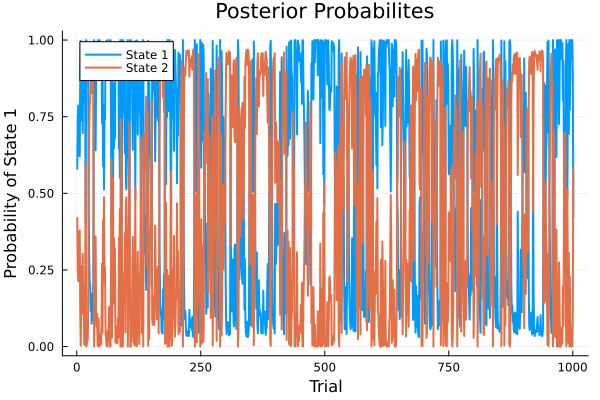

In [67]:
plot(γ[1, 5000:6000], title="Posterior Probabilites", xlabel="Trial", ylabel="Probability of State 1", label="State 1", linewidth=2)
plot!(γ[2, 5000:6000], label="State 2", linewidth=2)